In [1]:
# 匯入工單號
import pandas as pd
wo = pd.read_excel('WIP.xlsx')
wo.head(5)

,工單編號,產品類型,產線,填充需求數量,貼標需求數量,交期
0,1,310,A,4778,0,2023-06-22
1,2,240,C,3082,0,2023-08-05
2,3,6000,B,3742,0,2023-07-21
3,4,240,C,4665,0,2023-07-07
4,5,240,C,3593,0,2023-07-08


In [2]:
# 轉換加工時間
PROCESS_TIME = {
    ('A', 330): (3600/500, 0),
    ('A', 310): (3600/200, 0),
    ('A', 380): (3600/300, 0),
    ('A', 500): (3600/500, 0),
    ('A', 600): (3600/500, 0),
    ('B', 6000): (3600/180, 0),
    ('B', 20000): (3600/144, 0),
    ('B', 17250): (3600/336, 0),
    ('C', 240): (3600/168, 0),
    ('D', 330): (3600/500, 3600/40),
    ('D', 380): (3600/300, 3600/40),
    ('D', 500): (3600/500, 3600/250)
}

In [3]:
import random

class ORDER():
    def __init__(self, wo_id, wo_type, machine, num_fill, num_sticker, due):
        self.wo_id = wo_id
        self.wo_type = wo_type
        self.machine = machine
        self.num_fill = num_fill
        self.num_sticker = num_sticker
        self.due = due

order_seq = []

for row in range(len(wo)):
    wo_id = wo.iloc[row]['工單編號']
    wo_type = wo.iloc[row]['產品類型']
    machine = wo.iloc[row]['產線']
    num_fill = wo.iloc[row]['填充需求數量']
    num_sticker = wo.iloc[row]['貼標需求數量']
    due = wo.iloc[row]['交期']
    order = ORDER(wo_id, wo_type, machine, num_fill, num_sticker, due)
    order_seq.append(order)


In [4]:
from datetime import date, timedelta

def fitness(order_seq):
    # 初始化資料
    job = []
    start_time = []
    finish_time = []
    resource = []
    machine_state_ABC = {'A':0, 'B':0, 'C':0} # ABC機台狀況
    machine_state_D = 0 # D機台狀況
    machine_time_ABC = {'A':0, 'B':0, 'C':0} # ABC機台時間
    machine_time_D = 0  # D機台時間
    all_setup_time = 0 # 時間紀錄 
    all_tardiness_time = 0
    previous = None # 前一單產品類型
    today = date.today()
    today_timestamp = pd.Timestamp(today)
    
    for order in order_seq:
        wo_id = order.wo_id
        wo_type = order.wo_type
        machine = order.machine
        num_fill = order.num_fill
        num_sticker = order.num_sticker
        due = order.due
        # 計算填充時間跟貼標時間
        fill_time = round(num_fill * PROCESS_TIME[(machine, wo_type)][0],0)
        stick_time = round(num_sticker * PROCESS_TIME[(machine, wo_type)][1],0)
        setup_time = 20 * 60
        if previous == wo_type: # 若前一單與本單類型同，整備時間僅為5分鐘
            setup_time = 5*60
        all_setup_time += setup_time
        total_process_time = fill_time + stick_time + setup_time
        # print(f'排入工單編號:{wo_id}, 產線:{machine}, 產品類型:{wo_type}, 填充時間{fill_time}, 貼標時間:{stick_time}, 整備時間:{setup_time}, 總加工時間:{total_process_time}, DUE:{str(due)[:10]}')

        order_start_time = 0
        order_finish_time = 0

        if machine in ['A', 'B', 'C']:
            if sum(machine_state_ABC.values()) == 0: # 假如前一單是D排單
                order_start_time = machine_time_D # 開始時間為D佔用的最後時間
                order_finish_time = order_start_time + total_process_time # 加上本單作業時間
                machine_state_D = 0 # 釋放D機台
                machine_time_ABC[machine] = order_finish_time # 本單佔用機台最後時間
                machine_state_ABC[machine] = 1 # 更新佔用某機台
                # print(f'前單為D機台或此單為首單')

            elif sum(machine_state_ABC.values()) == 1: # 假如已有一台ABC機群運作，要判斷是否沿用同台或換台了
                previous_machine = ([current_machine for (current_machine, state) in machine_state_ABC.items() if state == 1])[0]
                if machine == previous_machine:
                    order_start_time = machine_time_ABC[machine]
                    order_finish_time = order_start_time + total_process_time
                    machine_time_ABC[machine] = order_finish_time # 本單佔用機台最後時間
                    # print('沿用同台，持續佔用')
                else:
                    order_start_time = machine_time_D # 開始時間為D佔用的最後時間
                    order_finish_time = order_start_time + total_process_time # 加上本單作業時間
                    machine_state_D = 0 # 釋放D機台
                    machine_time_ABC[machine] = order_finish_time # 本單佔用機台最後時間
                    machine_state_ABC[machine] = 1 # 更新佔用某機台
                    # print(f'插入非上一單機台')
            else :
                previous_machine = ([current_machine for (current_machine, state) in machine_state_ABC.items() if state == 1])
                if machine in previous_machine:
                    order_start_time = machine_time_ABC[machine]
                    order_finish_time = order_start_time + total_process_time
                    machine_time_ABC[machine] = order_finish_time # 本單佔用機台最後時間
                    # print('沿用同台，持續佔用')
                else:
                    ABC_list = [(pre_machine, time) for ((pre_machine,state), time) in (zip(machine_state_ABC.items(), machine_time_ABC.values())) if state == 1] # 找ABC佔用的情況跟最後時間
                    min_element = min(ABC_list, key=lambda x: x[1])
                    order_start_time = min_element[1] # 開始時間為D佔用的最後時間
                    order_finish_time = order_start_time + total_process_time # 加上本單作業時間
                    machine_state_ABC[min_element[0]] = 0 # 釋放D機台
                    machine_time_ABC[machine] = order_finish_time # 本單佔用機台最後時間
                    machine_state_ABC[machine] = 1 # 更新佔用某機台
                    # print(f'此單ABC機台已被佔用，需等待至佔用機台最早結束時間')
        else:
            if machine_state_D == 1:
                order_start_time = machine_time_D
                machine_time_D += total_process_time # 本單佔用機台最後時間
                order_finish_time = machine_time_D
                # print(f'繼續使用D機台')
            elif sum(machine_state_ABC.values()) > 0:
                ABC_list = [(pre_machine, time) for ((pre_machine,state), time) in (zip(machine_state_ABC.items(), machine_time_ABC.values())) if state == 1] # 找ABC佔用的情況跟最後時間
                min_element = max(ABC_list, key=lambda x: x[1])
                order_start_time = min_element[1] # 開始時間為佔用機台的最大時間
                order_finish_time = order_start_time + total_process_time # 加上本單作業時間
                for history in ABC_list:
                    machine_state_ABC[history[0]] = 0
                machine_time_D = order_finish_time # 本單佔用機台最後時間
                machine_state_D = 1 # 更新佔用某機台
                # print(f'此單前ABC機台已被佔用，需等待佔用機台結束後才可開工')
            else:
                order_start_time = machine_time_D
                machine_time_D = total_process_time # 本單佔用機台最後時間
                machine_state_D = 1 # 更新佔用某機台
                order_finish_time = machine_time_D
                # print(f'此單為首單')

        previous = wo_type
        finish_date = int(order_finish_time/(3600*24)) 
        tardiness = max((today_timestamp + timedelta(days=finish_date) - due).days,0)
        all_tardiness_time += tardiness
        # print(f'【真實】開始時間為{today_timestamp + timedelta(seconds=order_start_time)}，結束時間:{today_timestamp + timedelta(seconds=order_finish_time)}')
        # print(f'【時間戳記】開始時間: {int(order_start_time)}, 結束時間:{int(order_finish_time)}, 完工日期:{str(today_timestamp + timedelta(days=finish_date))[:10]}')
        # print(f'A:{machine_state_ABC["A"]}, B:{machine_state_ABC["B"]}, C:{machine_state_ABC["C"]}, D:{machine_state_D}')
        # print(f'A:{machine_time_ABC["A"]}, B:{machine_time_ABC["B"]}, C:{machine_time_ABC["C"]}, D:{machine_time_D}')

        job.append(wo_id)
        start_time.append(today_timestamp + timedelta(seconds=order_start_time))
        finish_time.append(today_timestamp + timedelta(seconds=order_finish_time))
        resource.append(machine)
        # print('------------------------------------------------------------------------------------------------------------------------------------------')

    max_ABC = max(machine_time_ABC.items(), key=lambda x: x[1])[1]
    maxspan = max_ABC
    if max_ABC < machine_time_D:
        maxspan = machine_time_D
    schedule = pd.DataFrame({"工單編號":job, "Start":start_time, "Finish":finish_time, "產線":resource})
    return maxspan, all_setup_time, all_tardiness_time*3600*24, schedule

a,b,c,d = fitness(order_seq)
print(f'maxspan:{a}, setup_total:{b}, tardiness_total:{c}')

maxspan:2969232.0, setup_total:31500, tardiness_total:18403200


In [5]:
import math
weighted_maxspan, weighted_setuptime, weighted_tardiness = 1, 0, 0

def GA():
    all_pop_order = []
    all_pop_fitness = []
    best_fit = []
    best_order = []
    # 初始解
    for _ in range(10000):
        shuffled_order_seq = random.sample(order_seq, len(order_seq))
        maxspan, setuptime, tardiness, sc = fitness(shuffled_order_seq)
        overall_fitnesee = weighted_maxspan * maxspan + weighted_setuptime * setuptime + weighted_tardiness * tardiness
        all_pop_order.append(shuffled_order_seq)
        all_pop_fitness.append(overall_fitnesee)
    
    for _ in range(1000): # 代數
        sorted_orders = sorted([(seq, fitness) for (seq, fitness) in zip(all_pop_order, all_pop_fitness)], key=lambda x:x[1])[:2]
        best_order.append(sorted_orders[0][0])
        best_fit.append(sorted_orders[0][1])
        all_pop_order = []
        all_pop_fitness = []
        for _ in range(1000): # 群體數
            # 選擇前兩名進行交配
            random_numbers = sorted(random.sample(range(0, len(order_seq)), 2))
            best_mother = sorted_orders[0][0]
            second_mother = sorted_orders[1][0]
            find_segement = best_mother[random_numbers[0]:random_numbers[1]+1]
            index_second_seg = (sorted([second_mother.index(ele) for ele in find_segement]))
            new_segment = best_mother[0:random_numbers[0]] + [second_mother[index] for index in index_second_seg] + best_mother[random_numbers[1]+1:]
        
            # 隨機變異
            rate = 0.9
            if (random.random() < rate):
                random_numbers = sorted(random.sample(range(0, len(order_seq)), 2))
                new_segment[random_numbers[0]], new_segment[random_numbers[1]] = new_segment[random_numbers[1]], new_segment[random_numbers[0]]
            maxspan, setuptime, tardiness, sc = fitness(new_segment)
            overall_fitnesee = weighted_maxspan * maxspan + weighted_setuptime * setuptime + weighted_tardiness * tardiness
            all_pop_order.append(new_segment.copy())
            all_pop_fitness.append(overall_fitnesee)

    return best_order, best_fit, sc

order_result, fitness_result, sc = GA()

In [332]:
import plotly.express as px
import pandas as pd

maxspan, setuptime, tardiness, sc = fitness(order_result[-1])
sc["Start"] = pd.to_datetime(sc["Start"])
sc["Finish"] = pd.to_datetime(sc["Finish"])
df = sc.sort_values(by="產線", ascending=False)

# Create a Gantt chart
fig = px.timeline(df, 
                  x_start="Start", 
                  x_end="Finish", 
                  y="產線", 
                  color="工單編號", 
                  title="Gantt Chart - by 機台")

# Show the chart
fig.show()
df = pd.merge(sc, wo, on='工單編號').drop(columns=['產線_y'])
df['遲繳'] =  df['Finish'] - df['交期'] 
df

,工單編號,Start,Finish,產線_x,產品類型,填充需求數量,貼標需求數量,交期,遲繳
0,12,2023-06-21 00:00:00,2023-06-21 21:10:00,C,240,3500,0,2023-07-05,-14 days +21:10:00
1,21,2023-06-21 00:00:00,2023-06-21 06:35:22,A,500,3128,0,2023-07-05,-14 days +06:35:22
2,3,2023-06-21 06:35:22,2023-06-21 22:25:22,A,310,3100,0,2023-06-24,-3 days +22:25:22
3,22,2023-06-21 22:25:22,2023-06-28 17:28:05,D,330,3131,6258,2023-06-27,1 days 17:28:05
4,28,2023-06-28 17:28:05,2023-06-30 08:50:05,D,380,3775,1058,2023-06-30,0 days 08:50:05
5,26,2023-06-30 08:50:05,2023-07-02 12:25:59,D,380,3027,1657,2023-07-02,0 days 12:25:59
6,5,2023-07-02 12:25:59,2023-07-05 03:35:41,D,380,4936,1865,2023-06-29,6 days 03:35:41
7,29,2023-07-05 03:35:41,2023-07-06 07:12:50,C,240,4584,0,2023-07-10,-4 days +07:12:50
8,8,2023-07-05 03:35:41,2023-07-05 13:23:46,A,600,4734,0,2023-07-07,-2 days +13:23:46
9,23,2023-07-05 13:23:46,2023-07-06 19:14:11,B,20000,4249,0,2023-07-07,-1 days +19:14:11


In [333]:
tardiness

4579200

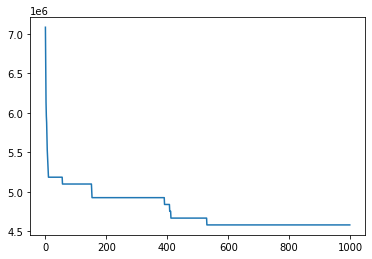

In [334]:
import matplotlib.pyplot as plt
plt.plot(fitness_result)